This notebook demonstrates fetching magnetic data, models, and residuals from VirES, and plotting them using cartopy. Requirements:
- `viresclient` (including pandas, xarray, cdflib etc.)
- `cartopy`

Some knowledge of `matplotlib`, `pandas`, `xarray`, `cartopy` is necessary

The notebook has several parts:

1. Fetching data residuals to a model
2. Fetching data and model values (and then calculating a residual locally)
3. Fetching residuals to a combined model directly
4. More complex combinations of models
5. Providing a custom .shc model
6. Using the orbit direction flags

---

# 1) Get B_NEC data at 10s sampling, residual to MCO_SHA_2C, for one day

Choose the `B_NEC` data and `MCO_SHA_2C` model, and request only the residuals (`B_NEC - B_NEC_MCO_SHA_2C`), at 10-second sampling. Fetch data from 1st January 2016, and load as an `xarray.Dataset`.

In [1]:
from viresclient import SwarmRequest
import datetime as dt

request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=["MCO_SHA_2C"],
    residuals=True,
    sampling_step="PT10S"
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)

ds = data.as_xarray()
ds

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.497MB)


<xarray.Dataset>
Dimensions:               (Timestamp: 8640, dim: 3)
Coordinates:
  * Timestamp             (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft            (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    Latitude              (Timestamp) float64 -72.5 -73.13 -73.76 ... 30.46 31.1
    Longitude             (Timestamp) float64 92.79 93.09 ... -95.37 -95.37
    Radius                (Timestamp) float64 6.834e+06 6.834e+06 ... 6.823e+06
    B_NEC_res_MCO_SHA_2C  (Timestamp, dim) float64 -3.214 -184.3 ... -3.146 19.8

## Use cartopy to plot the vertical component of the residual, over each polar region

Adapted from examples at https://scitools.org.uk/cartopy/docs/v0.15/gallery.html

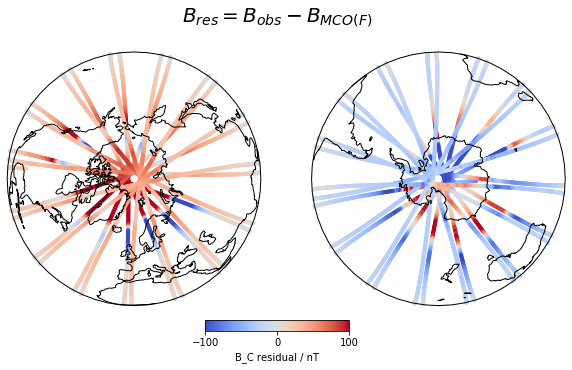

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
%matplotlib inline

def make_plot(ds, var, component="C", cmap=cm.coolwarm, norm=Normalize(vmin=-100,vmax=100)):
    component_to_idx = {"N":0, "E":1,"C": 2}

    fig = plt.figure(figsize=[10, 5])
    ax1 = plt.subplot(
        1, 2, 1,
        projection=ccrs.Orthographic(
            central_longitude=0.0, central_latitude=90.0
        )
    )
    ax2 = plt.subplot(
        1, 2, 2,
        projection=ccrs.Orthographic(
            central_longitude=0.0, central_latitude=-90.0
        )
    )

    def plot_hs(ax, ds):
        ax.scatter(
            ds.Longitude, ds.Latitude,
            c=ds[var][:,component_to_idx[component]],
            transform=ccrs.PlateCarree(),
            s=10, cmap=cmap, norm=norm
        )
        ax.set_global(); ax.coastlines()

    dsN = ds.where(ds["Latitude"] > 0)
    dsS = ds.where(ds["Latitude"] < 0)
    for ax, ds_subset in zip([ax1, ax2], [dsN, dsS]):
        plot_hs(ax, ds_subset)
    
    # cbar location [left, bottom, width, height] 
    ax_d = fig.add_axes([0.4,0.08,0.2,0.03]) 
    ColorbarBase(
        ax_d, cmap=cmap, norm=norm, orientation='horizontal',
        label="B_C residual / nT",
        ticks=[norm.vmin, (norm.vmax+norm.vmin)/2, norm.vmax]
    )

    return fig

fig = make_plot(ds, "B_NEC_res_MCO_SHA_2C")
fig.suptitle("$B_{res} = B_{obs} - B_{MCO (F)}$", fontsize=20);

There is a hemispheric bias because we haven't accounted for the magnetospheric field

---

# 2) Redo the above, using MCO_SHA_2F and MMA_SHA_2F

Choose the `B_NEC` data and `MCO_SHA_2F`, `MMA_SHA_2F-Primary`, and `MMA_SHA_2F-Secondary` models at 10-second sampling. This time fetch the data and model values themselves (instead of the residuls). Fetch data from 1st January 2016, and load as an `xarray.Dataset`.

In [3]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=["MCO_SHA_2F", "MMA_SHA_2F-Primary", "MMA_SHA_2F-Secondary"],
    sampling_step="PT10S"
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)
ds = data.as_xarray()
ds

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (1.121MB)


<xarray.Dataset>
Dimensions:                     (Timestamp: 8640, dim: 3)
Coordinates:
  * Timestamp                   (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft                  (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                    (Timestamp) float64 -72.5 -73.13 ... 30.46 31.1
    Longitude                   (Timestamp) float64 92.79 93.09 ... -95.37
    Radius                      (Timestamp) float64 6.834e+06 ... 6.823e+06
    B_NEC                       (Timestamp, dim) float64 -1.581e+03 ... 3.356e+04
    B_NEC_MCO_SHA_2F            (Timestamp, dim) float64 -1.576e+03 ... 3.354e+04
    B_NEC_MMA_SHA_2F-Primary    (Timestamp, dim) float64 -19.42 2.823 ... 29.79
    B_NEC_MMA_SHA_2F-Secondary  (Timestamp, dim) float64 -4.484 ... -3.057

Evaluate the custom residual $B_{res} = B_{obs} - B_{MCO (F)} - B_{MMA (F)}$ and append it to the Dataset:

In [4]:
ds["Bres"] = ds["B_NEC"] - ds["B_NEC_MCO_SHA_2F"] \
                         - ds["B_NEC_MMA_SHA_2F-Primary"] \
                         - ds["B_NEC_MMA_SHA_2F-Secondary"]
ds

<xarray.Dataset>
Dimensions:                     (Timestamp: 8640, dim: 3)
Coordinates:
  * Timestamp                   (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft                  (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                    (Timestamp) float64 -72.5 -73.13 ... 30.46 31.1
    Longitude                   (Timestamp) float64 92.79 93.09 ... -95.37
    Radius                      (Timestamp) float64 6.834e+06 ... 6.823e+06
    B_NEC                       (Timestamp, dim) float64 -1.581e+03 ... 3.356e+04
    B_NEC_MCO_SHA_2F            (Timestamp, dim) float64 -1.576e+03 ... 3.354e+04
    B_NEC_MMA_SHA_2F-Primary    (Timestamp, dim) float64 -19.42 2.823 ... 29.79
    B_NEC_MMA_SHA_2F-Secondary  (Timestamp, dim) float64 -4.484 ... -3.057
    Bres                        (Timestamp, dim) float64 18.68 -186.3 ... -5.289

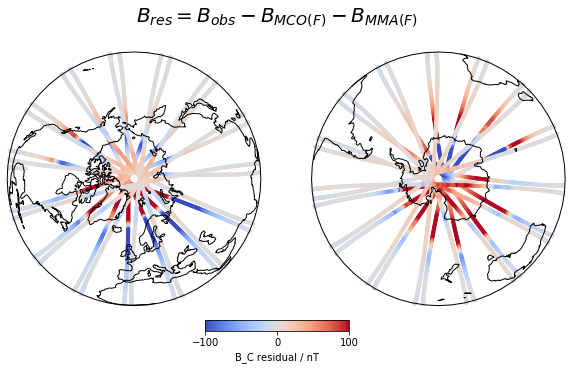

In [5]:
fig = make_plot(ds, "Bres")
fig.suptitle("$B_{res} = B_{obs} - B_{MCO (F)} - B_{MMA (F)}$", fontsize=20);

This shows the magnetic disturbance created around the auroral region during this day.

## Plot the same data as a time series

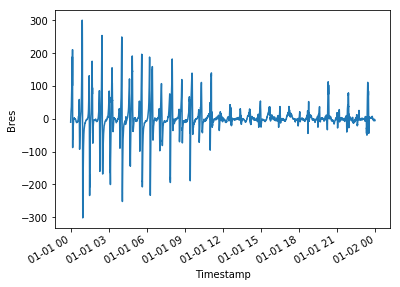

In [6]:
ds["Bres"][:,2].plot();

This shows the evolution of the disturbance with time.

---

# 3) Get the combined model residual directly with the new VirES "model expressions" functionality, as of viresclient v0.2.6

New models can be specified by assigning them as a list of strings `"NewModel = ..."`, named however you like, or as a dictionary. (TODO: Reference to docs here...) Here we call our new model "Combined_model", and it becomes available under the same name in the generated data. Note that extra quotation marks are needed distinguish between parts of model names (`MMA_SHA_2F-Secondary`) and arithmetic minus (`-`)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.498MB)


<xarray.Dataset>
Dimensions:                   (Timestamp: 8640, dim: 3)
Coordinates:
  * Timestamp                 (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft                (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                  (Timestamp) float64 -72.5 -73.13 ... 30.46 31.1
    Longitude                 (Timestamp) float64 92.79 93.09 ... -95.37 -95.37
    Radius                    (Timestamp) float64 6.834e+06 ... 6.823e+06
    B_NEC_res_Combined_model  (Timestamp, dim) float64 18.68 -186.3 ... -5.289


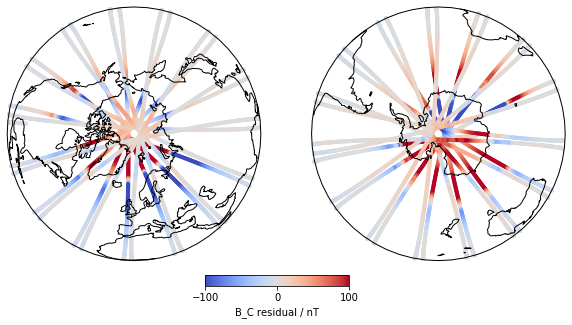

In [7]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=[
        "'Combined_model' = 'MCO_SHA_2F' + 'MMA_SHA_2F-Primary' + 'MMA_SHA_2F-Secondary'"
    ],
#     models={
#         'Combined_model': "'MCO_SHA_2F' + 'MMA_SHA_2F-Primary' + 'MMA_SHA_2F-Secondary'"
#     },
    residuals=True,
    sampling_step="PT10S"
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)
ds = data.as_xarray()
print(ds)
fig = make_plot(ds, "B_NEC_res_Combined_model")

In [8]:
print(request)

Request details:
collection_ids: {'X': ['SW_OPER_MAGA_LR_1B']}
model_expression: 'Combined_model'='MCO_SHA_2F' + 'MMA_SHA_2F-Primary' + 'MMA_SHA_2F-Secondary'
begin_time: 2016-01-01 00:00:00
end_time: 2016-01-02 00:00:00
variables: ['B_NEC_res_Combined_model']
filters: None
sampling_step: PT10S
response_type: application/x-cdf
custom_shc: None


# 4) Complex combinations are possible

- Combinations of models (+ -)
- Evaluating between min/max SH degree
- Reusing new model names in subsequent expressions

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:22, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (1.538MB)


<xarray.Dataset>
Dimensions:               (Timestamp: 8640, dim: 3)
Coordinates:
  * Timestamp             (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft            (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    Latitude              (Timestamp) float64 -72.5 -73.13 -73.76 ... 30.46 31.1
    Longitude             (Timestamp) float64 92.79 93.09 ... -95.37 -95.37
    Radius                (Timestamp) float64 6.834e+06 6.834e+06 ... 6.823e+06
    B_NEC                 (Timestamp, dim) float64 -1.581e+03 ... 3.356e+04
    B_NEC_CHAOS-6-custom  (Timestamp, dim) float64 -1.6e+03 ... 3.356e+04
    B_NEC_CI-internal     (Timestamp, dim) float64 -1.613e+03 ... 3.356e+04
    B_NEC_CI-external     (Timestamp, dim) float64 -7.617 5.01 ... 0.1505 -6.731
    B_NEC_CI-full         (Timestamp, dim) float64 -1.62e+03 ... 3.356e+04
    B_NEC_CHAOS-CI-diff   (Timestamp, dim) float64 20.18 -15.73 ... 0.8094


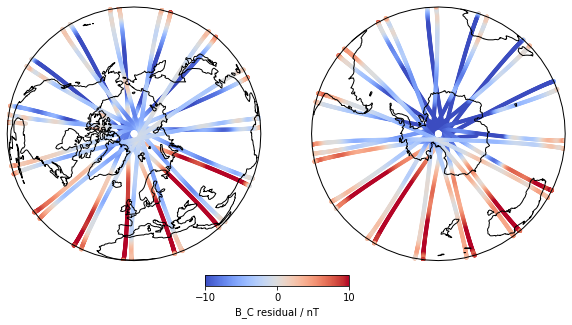

In [9]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models={
        "CHAOS-6-custom":
            """
            'CHAOS-6-Core'(min_degree=1, max_degree=20) +
            'CHAOS-6-Static'(min_degree=21, max_degree=80) +
            'CHAOS-6-MMA-Primary'(min_degree=1, max_degree=1) +
            'CHAOS-6-MMA-Secondary'(min_degree=1, max_degree=1)
            """,
        "CI-internal":
            """
            'MCO_SHA_2C' +
            'MLI_SHA_2C' +
            'MMA_SHA_2C-Primary' +
            'MIO_SHA_2C-Primary'
            """,
        "CI-external":
            """
            'MMA_SHA_2C-Secondary' +
            'MIO_SHA_2C-Secondary'
            """,
        "CI-full": "'CI-internal' + 'CI-external'",
        "CHAOS-CI-diff": "'CHAOS-6-custom' - 'CI-full'"
    },
#     residuals=True,
    sampling_step="PT10S"
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)
ds = data.as_xarray()
print(ds)
fig = make_plot(ds, "B_NEC_CHAOS-CI-diff", norm=Normalize(-10, 10))

# 5) Use in combination with a custom uploaded .shc model

If `custom_model` is also provided, then that model will be available in the `models` expressions as `"Custom_Model"`. Here the difference between LCS-1 and MLI_SHA_2D is shown, with both evaluated up to degree 80 (at the locations of Swarm Alpha orbits over four days). (LCS-1 can be downloaded from http://www.spacecenter.dk/files/magnetic-models/LCS-1/LCS-1.shc)

In [10]:
request.available_models("D", details=False)

['MCO_SHA_2D', 'MLI_SHA_2D', 'MIO_SHA_2D-Primary', 'MIO_SHA_2D-Secondary']

`.get_model_info()` can be used with the same `models` and `custom_model` kwargs as `.set_products()` to query the server on min/max SH degree and time validity of both original and redefined models:

In [11]:
request.get_model_info(
    models=["MLI_SHA_2D"],
    custom_model="LCS-1.shc"
)

{'MLI_SHA_2D': {'expression': 'MLI_SHA_2D(max_degree=133,min_degree=16)',
  'validity': {'start': '0001-01-01T00:00:00Z',
   'end': '4000-01-01T00:00:00Z'}},
 'Custom_Model': {'expression': 'Custom_Model(max_degree=185,min_degree=1)',
  'validity': {'start': '0001-01-01T00:00:00Z',
   'end': '4000-01-01T00:00:00Z'}}}

In [12]:
request.get_model_info(
    models={
        "MLI_SHA_2D": "MLI_SHA_2D(min_degree=1, max_degree=80)",
        "LCS": "Custom_Model(min_degree=1, max_degree=80)",
        "LCS-SwarmMLI": "LCS - MLI_SHA_2D"
    },
    custom_model="LCS-1.shc",
)

{'MLI_SHA_2D': {'expression': 'MLI_SHA_2D(max_degree=80,min_degree=16)',
  'validity': {'start': '0001-01-01T00:00:00Z',
   'end': '4000-01-01T00:00:00Z'}},
 'LCS': {'expression': 'Custom_Model(max_degree=80,min_degree=1)',
  'validity': {'start': '0001-01-01T00:00:00Z',
   'end': '4000-01-01T00:00:00Z'}},
 'LCS-SwarmMLI': {'expression': 'LCS(max_degree=80,min_degree=1) - MLI_SHA_2D(max_degree=80,min_degree=16)',
  'validity': {'start': '0001-01-01T00:00:00Z',
   'end': '4000-01-01T00:00:00Z'}},
 'Custom_Model': {'expression': 'Custom_Model(max_degree=185,min_degree=1)',
  'validity': {'start': '0001-01-01T00:00:00Z',
   'end': '4000-01-01T00:00:00Z'}}}

In [13]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    custom_model="LCS-1.shc",
    models={
        "MLI_SHA_2D": "MLI_SHA_2D(min_degree=1, max_degree=80)",
        "LCS": "Custom_Model(min_degree=1, max_degree=80)",
        "LCS-SwarmMLI": "LCS - MLI_SHA_2D"
    },
    sampling_step="PT10S"
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,4)
)
ds = data.as_xarray()
ds

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:21, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (3.35MB)


<xarray.Dataset>
Dimensions:             (Timestamp: 25920, dim: 3)
Coordinates:
  * Timestamp           (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-03T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft          (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    Latitude            (Timestamp) float64 -72.5 -73.13 ... -50.82 -50.18
    Longitude           (Timestamp) float64 92.79 93.09 93.41 ... -102.9 -102.9
    Radius              (Timestamp) float64 6.834e+06 6.834e+06 ... 6.833e+06
    B_NEC               (Timestamp, dim) float64 -1.581e+03 ... -2.665e+04
    B_NEC_MLI_SHA_2D    (Timestamp, dim) float64 -0.2985 2.652 ... 0.1393 1.455
    B_NEC_LCS           (Timestamp, dim) float64 -0.2788 2.623 ... -0.6211
    B_NEC_LCS-SwarmMLI  (Timestamp, dim) float64 0.01969 -0.02892 ... -2.076

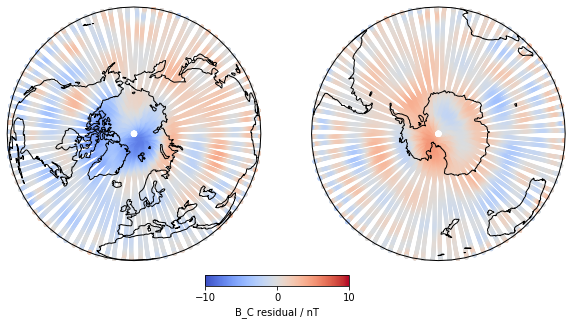

In [14]:
fig = make_plot(ds, "B_NEC_LCS-SwarmMLI", norm=Normalize(-10, 10))

# 6) Orbit direction flag

Filter by the orbit direction flag to visualise the data (from part 3) separately for each local time sector. 

- `OrbitDirection`:
    - +1 : ascending in latitude
    - -1 : descending in latitude
- `QDOrbitDirection`:
    - +1 : ascending in quasi-dipole latitude
    - -1 : descending in quasi-dipole latitude

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.261MB)


<xarray.Dataset>
Dimensions:                   (Timestamp: 4415, dim: 3)
Coordinates:
  * Timestamp                 (Timestamp) datetime64[ns] 2016-01-01T00:01:30 ... 2016-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft                (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                  (Timestamp) float64 -78.15 -78.77 ... 30.46 31.1
    Longitude                 (Timestamp) float64 96.73 97.43 ... -95.37 -95.37
    Radius                    (Timestamp) float64 6.834e+06 ... 6.823e+06
    B_NEC_res_Combined_model  (Timestamp, dim) float64 2.731 -180.5 ... -5.289


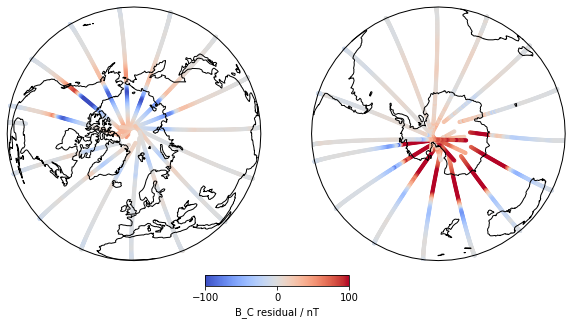

In [15]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=[
        "'Combined_model' = 'MCO_SHA_2F' + 'MMA_SHA_2F-Primary' + 'MMA_SHA_2F-Secondary'"
    ],
    residuals=True,
#     auxiliaries=["OrbitDirection", "QDOrbitDirection"],
    sampling_step="PT10S"
)
request.set_range_filter("QDOrbitDirection", 1, 1)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)
ds = data.as_xarray()
print(ds)
fig = make_plot(ds, "B_NEC_res_Combined_model")

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.25MB)


<xarray.Dataset>
Dimensions:                   (Timestamp: 4225, dim: 3)
Coordinates:
  * Timestamp                 (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:24:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft                (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Latitude                  (Timestamp) float64 -72.5 -73.13 ... -75.78 -76.41
    Longitude                 (Timestamp) float64 92.79 93.09 ... 102.4 102.9
    Radius                    (Timestamp) float64 6.834e+06 ... 6.834e+06
    B_NEC_res_Combined_model  (Timestamp, dim) float64 18.68 -186.3 ... 99.51


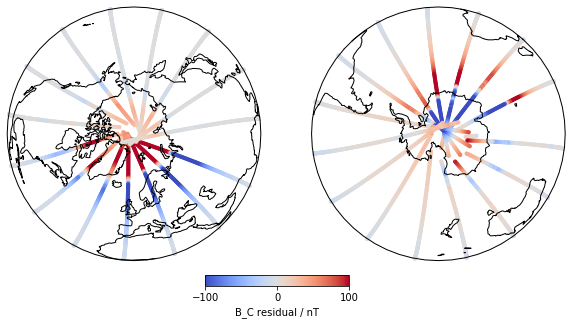

In [16]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=[
        "'Combined_model' = 'MCO_SHA_2F' + 'MMA_SHA_2F-Primary' + 'MMA_SHA_2F-Secondary'"
    ],
    residuals=True,
#     auxiliaries=["OrbitDirection", "QDOrbitDirection"],
    sampling_step="PT10S"
)
request.set_range_filter("QDOrbitDirection", -1, -1)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)
ds = data.as_xarray()
print(ds)
fig = make_plot(ds, "B_NEC_res_Combined_model")